在前一个猫狗分类网络里，过拟合很快产生，下面将使用一些技术来处理这个问题。

In [1]:
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers
import matplotlib.pyplot as plt

首先增加一个 `Dropout` 层。

In [3]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [4]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

然后对图片进行增量化处理，主要是为了在有限的数据里产生更多的数据，keras 提供了一些基本工具来达到这个目的。比如将图片平移一下，旋转一下，或者翻转一下。通过这个方式可以基于原本的数据集产生更多类似的，但是新的数据。下面是一个例子。

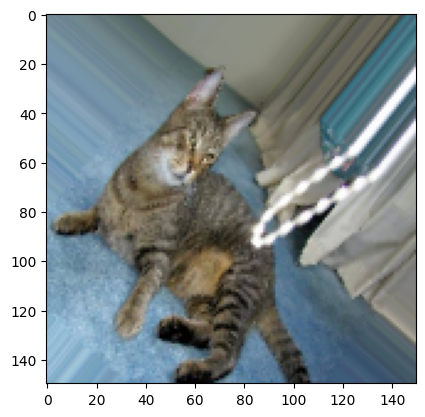

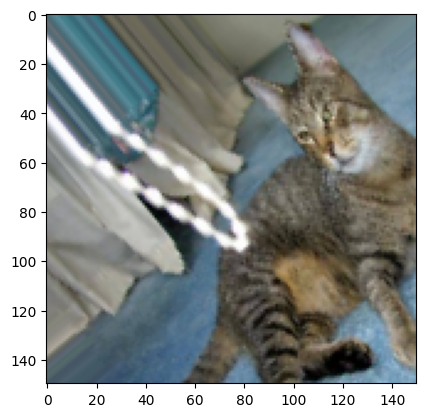

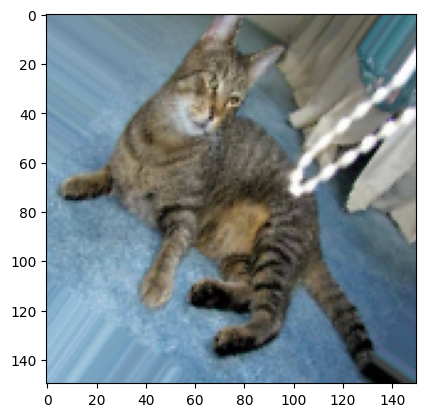

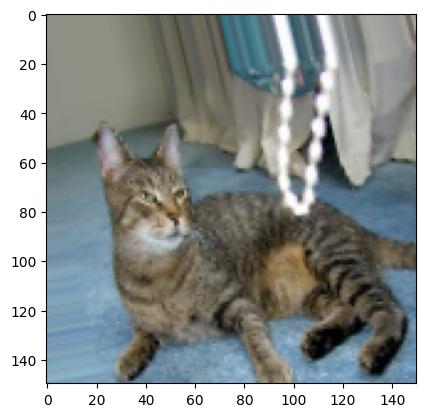

In [2]:
import os
from keras.preprocessing import image

datagen = image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_cats_dir = '/Users/bifnudozhao/Projects/ai-playground/datasets/train/cats'

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# choose one image
img_path = fnames[3]

img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
# reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = '/Users/bifnudozhao/Projects/ai-playground/datasets/train'
validation_dir = '/Users/bifnudozhao/Projects/ai-playground/datasets/validation'
test_dir = '/Users/bifnudozhao/Projects/ai-playground/datasets/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
# !!! The validation data shouldn't be augmented
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150), # resize image to 150 x 150
    batch_size=32,
    class_mode='binary'
)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150), # resize image to 150 x 150
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.


Found 1000 images belonging to 2 classes.


In [8]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50
)

/var/folders/63/hmm24s352qv_4vs09n66p97m0000gn/T/ipykernel_9056/32973454.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
100/100 [==============================] - 14s 135ms/step - loss: 0.6938 - accuracy: 0.5215 - val_loss: 0.6842 - val_accuracy: 0.5060


In [12]:
model.save('/Users/bifnudozhao/Projects/ai-playground/results/cats_and_dogs_small_2.keras')

In [13]:
import matplotlib.pyplot as plt

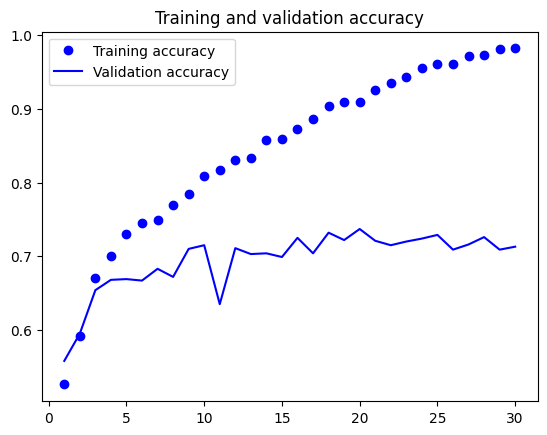

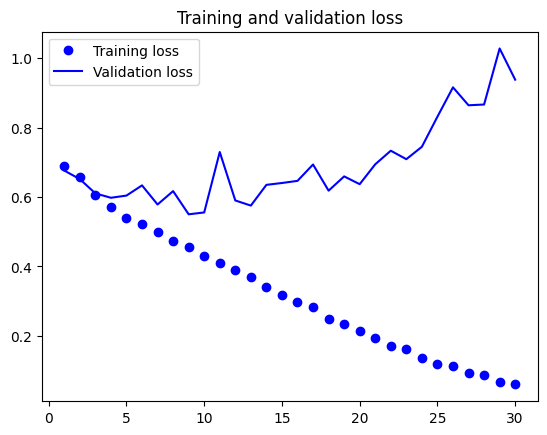

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

从上图可以看出，这是典型的过拟合。训练数据的正确率一直在上升，误差一直在下降，但是验证数据的正确率就只停在了 70% 左右，而误差也在上升。